In [1]:
# Checkout www.pygimli.org for more examples


# Crosshole traveltime tomography

Seismic and ground penetrating radar (GPR) methods are frequently applied to
image the shallow subsurface. While novel developments focus on inverting the
full waveform, ray-based approximations are still widely used in practice and
offer a computationally efficient alternative.
Here, we demonstrate the modelling of traveltimes and their inversion for the
underlying slowness distribution for a crosshole scenario.

We start by importing the necessary packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.traveltime as tt

pg.utils.units.quants['vel']['cMap'] = 'inferno_r'

## Geometry setup
Next, we build the crosshole acquisition geometry with two shallow boreholes.



In [3]:
# Acquisition parameters
bh_spacing = 20.0
bh_length = 25.0
sensor_spacing = 2.5

world = mt.createRectangle(start=[0, -(bh_length + 3)], end=[bh_spacing, 0.0],
                           marker=0)

depth = -np.arange(sensor_spacing, bh_length + sensor_spacing, sensor_spacing)

sensors = np.zeros((len(depth) * 2, 2))  # two boreholes
sensors[len(depth):, 0] = bh_spacing  # x
sensors[:, 1] = np.hstack([depth] * 2)  # y

Traveltime calculations work on unstructured meshes and structured grids. We
demonstrate this here by simulating the synthetic data on an unstructured
mesh and inverting it on a simple structured grid.



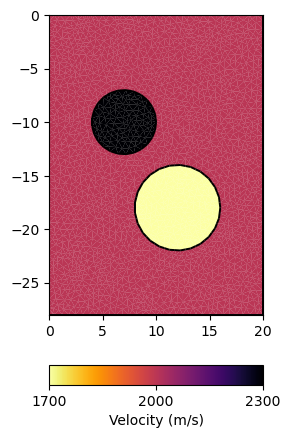

In [4]:
# Create forward model and mesh
c0 = mt.createCircle(pos=(7.0, -10.0), radius=3, nSegments=25, marker=1)
c1 = mt.createCircle(pos=(12.0, -18.0), radius=4, nSegments=25, marker=2)
geom = world + c0 + c1
for sen in sensors:
    geom.createNode(sen)

mesh_fwd = mt.createMesh(geom, quality=34, area=0.25)
model = np.array([2000., 2300, 1700])[mesh_fwd.cellMarkers()]
ax, cb = pg.show(mesh_fwd, model, logScale=False,
                 label=pg.unit('vel'), cMap=pg.cmap('vel'), nLevs=3)

## Synthetic data generation
Next, we create an empty DataContainer and fill it with sensor positions and
all possible shot-receiver pairs for the two-borehole scenario.



In [5]:
scheme = tt.createCrossholeData(sensors)

The forward simulation is performed with a few lines of code. We initialize
an instance of the Refraction manager and call its `simulate` function with
the mesh, the scheme and the slowness model (1 / velocity). We also add 0.1%
relative and 10 microseconds of absolute noise.

Secondary nodes allow for more accurate forward simulations. Check out the
paper by [Giroux & Larouche (2013)](https://doi.org/10.1016/j.cageo.2012.12.005) to learn more about it.



04/07/24 - 18:46:57 - pyGIMLi - INFO - Creating refined mesh (secnodes: 4) to solve forward task.


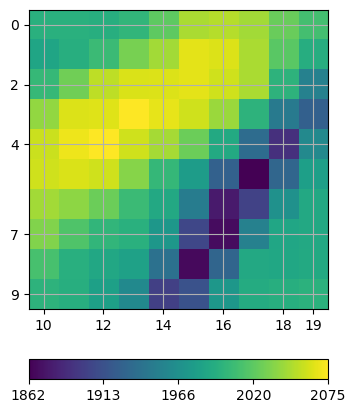

In [6]:
mgr = tt.TravelTimeManager()
data = tt.simulate(mesh=mesh_fwd, scheme=scheme, slowness=1./model,
                   secNodes=4, noiseLevel=0.001, noiseAbs=1e-5, seed=1337)

ax, cb = tt.showVA(data, usePos=False)

## Inversion
Now we create a structured grid as inversion mesh



04/07/24 - 18:47:04 - pyGIMLi - INFO - Found 1 regions.
04/07/24 - 18:47:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
04/07/24 - 18:47:04 - pyGIMLi - INFO - Creating refined mesh (secnodes: 3) to solve forward task.
04/07/24 - 18:47:04 - pyGIMLi - INFO - Create constant starting model: 0.0005007157384361097
04/07/24 - 18:47:04 - pyGIMLi - INFO - Created startmodel from forward operator: 1408, min/max=0.000501/0.000501
04/07/24 - 18:47:04 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x000001930D310D60>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001930D310F90>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001930D294E50>
min/max (data): 0.0096/0.02
min/max (error): 0.17%/0.2%
min/max (start model): 5.0e-04/5.0e-04
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  192.69
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   27.95 (dPhi = 83.27%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    3.33 (dPhi = 79.88%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.38 (dPhi = 25.49%) lam: 1000.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.48 (dPhi = 1

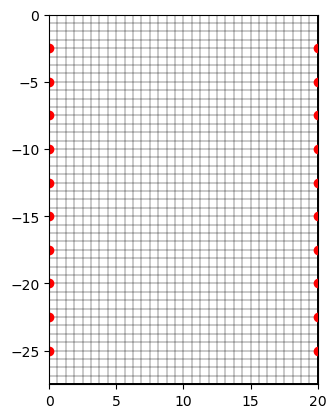

In [7]:
refinement = 0.25
x = np.arange(0, bh_spacing + refinement, sensor_spacing * refinement)
y = -np.arange(0.0, bh_length + 3, sensor_spacing * refinement)
mesh = pg.meshtools.createGrid(x, y)

ax, _ = pg.show(mesh, hold=True)
ax.plot(sensors[:, 0], sensors[:, 1], "ro")

invmodel = mgr.invert(data, mesh=mesh, secNodes=3, lam=1000, zWeight=1.0,
                      useGradient=False, verbose=True)
print("chi^2 = {:.2f}".format(mgr.inv.chi2()))  # Look at the data fit

Finally, we visualize the true model and the inversion result next to each
other.



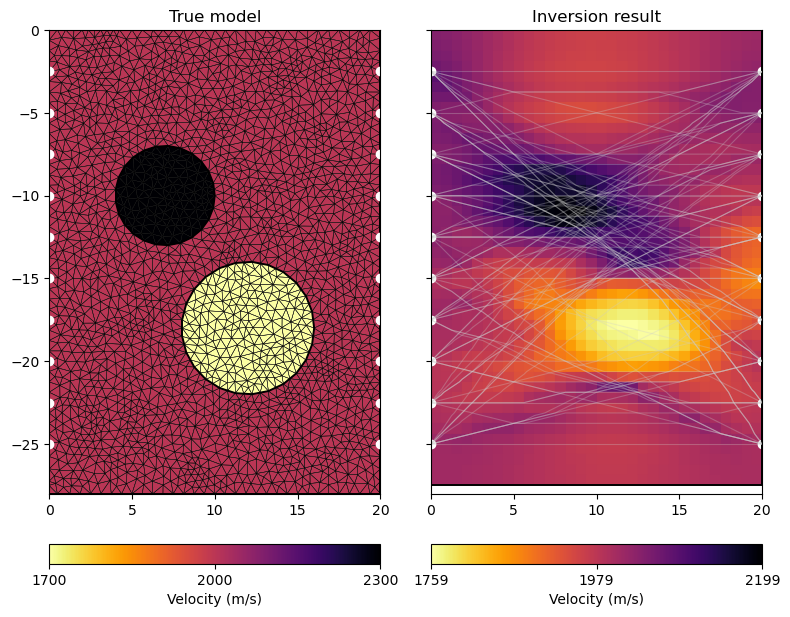

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7), sharex=True, sharey=True)
ax1.set_title("True model")
ax2.set_title("Inversion result")

ax, cb = pg.show(mesh_fwd, model, ax=ax1, showMesh=True,
                 label=pg.unit('vel'), cMap=pg.cmap('vel'), nLevs=3)

for ax in (ax1, ax2):
    ax.plot(sensors[:, 0], sensors[:, 1], "wo")

mgr.showResult(ax=ax2, logScale=False, nLevs=3)
mgr.drawRayPaths(ax=ax2, color="0.8", alpha=0.3)
fig.tight_layout()

## Coverage and ray paths
Note how the rays are attracted by the high velocity anomaly while
circumventing the low-velocity region.
This is also reflected in the coverage, which can be visualized as follows:



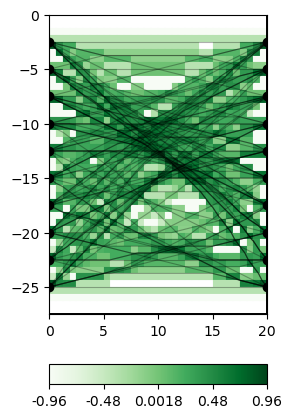

In [9]:
fig, ax = plt.subplots()
mgr.showCoverage(ax=ax, cMap="Greens")
mgr.drawRayPaths(ax=ax, color="k", alpha=0.3)
p = ax.plot(sensors[:, 0], sensors[:, 1], "ko")

White regions indicate the model null space, i.e. cells that are not
traversed by any ray.

